## Modelo de Pronóstico Precio Azúcar No. 11 US Futures

El contrato de **Azúcar No. 11** es el contrato mundial de referencia para el comercio de azúcar cruda (Bolsa de Futuros de Nueva York, The Coffee, Sugar and Cocoa Exchange CSCE). El contrato define el precio de la entrega física de azúcar cruda de caña FOB a un puerto dentro del país de origen del azúcar. El peso del contrato es de 112,000 libras. El **precio se especifíca en centavos por libra** a dos decimales de precisión.

Se presentan un modelo de **pronóstico** para la *Precio de Azúcar No. 11* en centavos de dólar por libra, utilizando un **Modelo de Regresión por Ordinary Least Squares**.

En este enfoque se utiliza únicamente **regresión**, y se presenta para conocer los factores de importancia que determinan el precio del contrato.

La información de precios, se obtienen de los datos publicados para US *Sugar #11 Futures* por **investing.com**

(https://www.investing.com/commodities/us-sugar-no11-historical-data)

Los datos de producción
https://data-explorer.oecd.org/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler

### Sugar No. 11 Futures Price Dataset


In [2]:
# .csv Sugar Prices No. 11
df_s11_month = pd.read_csv("Sugar_11.csv")
df_s11_month = df_s11_month.iloc[::-1]
df_s11_month['Date'] = pd.to_datetime(df_s11_month['Date'],format='%m/%d/%Y')
df_s11_month = df_s11_month.set_index('Date')
df_s11_month = df_s11_month.asfreq('MS')
df_s11_month

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1993-01-01,8.30,8.33,8.69,8.07,222.80K,-1.31%
1993-02-01,9.63,8.28,10.00,7.96,162.11K,16.02%
1993-03-01,11.89,9.94,12.53,9.79,237.84K,23.47%
1993-04-01,12.33,11.83,12.75,10.30,148.67K,3.70%
1993-05-01,10.76,12.73,13.26,10.52,226.42K,-12.73%
...,...,...,...,...,...,...
2024-03-01,22.52,21.58,22.59,20.54,55.32K,-0.27%
2024-04-01,19.41,22.23,22.49,18.97,1.33M,-13.81%
2024-05-01,18.30,19.48,20.00,17.95,1.10M,-5.72%


<Axes: title={'center': 'US Sugar No. 11 Futures Price (USD cents/pound)'}, xlabel='Date'>

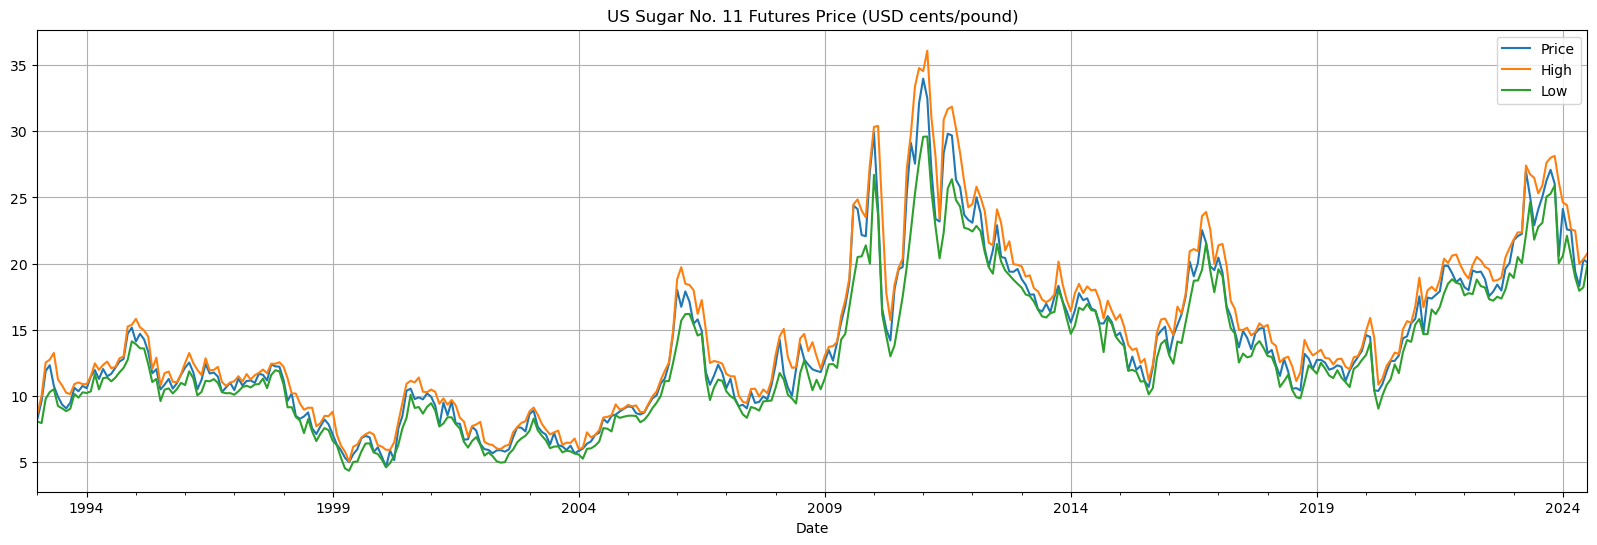

In [3]:
df_s11_month[['Price','High','Low']].plot(figsize=(20,6),grid=True,title='US Sugar No. 11 Futures Price (USD cents/pound)')

In [4]:
## Get Annual Means
df_s11 = pd.DataFrame(df_s11_month['Price'].groupby(by=[df_s11_month.index.year]).mean())
df_s11['Date'] = pd.to_datetime(df_s11.index,format='%Y')
df_s11 = df_s11.set_index('Date')
df_s11.head()

,Price
Date,
1993-01-01,10.210833
1994-01-01,12.328333
1995-01-01,12.165000
1996-01-01,11.460833
1997-01-01,11.430833


### Organisation for Economic Co-operation and Development Dataset

In [5]:
# OECD Dataset for Brazil and India
df_countries = pd.read_csv("INDIA_BRAZIL.csv")
df_countries.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,COUNTRY,Country,COMMODITY,Commodity,VARIABLE,Variable,...,OBS_VALUE,Observation Value,OBS_STATUS,Observation Status,UNIT_MEASURE,Unit of Measures,UNIT_MULT,Multiplier,BASE_PER,Base reference period
0,DATAFLOW,OECD:DF_HIGH_AGLINK_2017(1.0),OECD-FAO Agricultural Outlook 2017-2026,I,IND,India,ET,Ethanol,NT,Trade balance,...,0.0,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DATAFLOW,OECD:DF_HIGH_AGLINK_2017(1.0),OECD-FAO Agricultural Outlook 2017-2026,I,IND,India,SU,Sugar (tq),NT,Trade balance,...,0.0,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DATAFLOW,OECD:DF_HIGH_AGLINK_2017(1.0),OECD-FAO Agricultural Outlook 2017-2026,I,IND,India,SUR,Raw sugar (tq),NT,Trade balance,...,0.0,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DATAFLOW,OECD:DF_HIGH_AGLINK_2017(1.0),OECD-FAO Agricultural Outlook 2017-2026,I,IND,India,SUW,White sugar (tq),NT,Trade balance,...,0.0,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DATAFLOW,OECD:DF_HIGH_AGLINK_2017(1.0),OECD-FAO Agricultural Outlook 2017-2026,I,IND,India,ET,Ethanol,NT,Trade balance,...,0.0,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Diccionario de Variables

In [6]:
df_dict = df_countries[['COMMODITY','VARIABLE','COUNTRY','Commodity','Variable','Country']].copy()
df_dict['key'] = df_dict['VARIABLE']+' '+ df_dict['COMMODITY'] + ' ' + df_dict['COUNTRY']
df_dict['value'] = df_dict['Variable']+' '+ df_dict['Commodity'] + ' ' + df_dict['Country']
df_dict = df_dict.filter(['key', 'value'])
df_diccionario = {'keys':df_dict['key'].unique(),'values':df_dict['value'].unique()}
diccionario =  pd.DataFrame(df_diccionario)
diccionario.set_index('keys',inplace=True)
diccionario = diccionario.to_dict()
diccionario

{'values': {'NT ET IND': 'Trade balance Ethanol India',
  'NT SU IND': 'Trade balance Sugar (tq) India',
  'NT SUR IND': 'Trade balance Raw sugar (tq) India',
  'NT SUW IND': 'Trade balance White sugar (tq) India',
  'QP SU IND': 'Production Sugar (tq) India',
  'QP ET IND': 'Production Ethanol India',
  'QP SCA BRA': 'Production Sugar cane Brazil',
  'NT SUR BRA': 'Trade balance Raw sugar (tq) Brazil',
  'NT SUW BRA': 'Trade balance White sugar (tq) Brazil',
  'NT SU BRA': 'Trade balance Sugar (tq) Brazil',
  'PP SUR BRA': 'Producer price Raw sugar (tq) Brazil',
  'QP SU BRA': 'Production Sugar (tq) Brazil',
  'QP SCA IND': 'Production Sugar cane India',
  'PP SCA BRA': 'Producer price Sugar cane Brazil',
  'PP SUW BRA': 'Producer price White sugar (tq) Brazil',
  'QP__SCA ET BRA': 'Ethanol production from sugar cane Ethanol Brazil',
  'NT ET BRA': 'Trade balance Ethanol Brazil',
  'PP ET BRA': 'Producer price Ethanol Brazil',
  'QP ET BRA': 'Production Ethanol Brazil'}}

In [7]:
def extractor(df_countries,country,commodity,variable):
    
    df_extraction = df_countries[(df_countries['COUNTRY']==country) & (df_countries['COMMODITY']==commodity) & (df_countries['VARIABLE']==variable)]
    df_extraction = df_extraction[['TIME_PERIOD','OBS_VALUE']].reset_index()
    df_extraction.drop('index',axis=1,inplace=True)
    df_extraction['TIME_PERIOD'] = pd.to_datetime(df_extraction['TIME_PERIOD'],format='%Y')
    df_extraction = df_extraction.sort_values(by=['TIME_PERIOD'],ascending=True)
    df_extraction = df_extraction.set_index('TIME_PERIOD')
    df_extraction.rename(columns={"OBS_VALUE": str(variable)+" "+str(commodity)+" "+str(country)},inplace=True)
    
    return df_extraction
    

In [8]:
# Brazil Production
df_brazil_production = extractor(df_countries,'BRA','SU','QP')
df_brazil_production_trade = extractor(df_countries,'BRA','SU','NT')
df_brazil_sugarcane_price = extractor(df_countries,'BRA','SCA','PP')
df_brazil_raw_sugar_price = extractor(df_countries,'BRA','SUR','PP')
df_brazil_white_sugar_price = extractor(df_countries,'BRA','SUW','PP')
df_brazil_raw_sugar_trade = extractor(df_countries,'BRA','SUR','NT')
df_brazil_white_sugar_trade = extractor(df_countries,'BRA','SUW','NT')
df_brazil_ethanol_sugarcane = extractor(df_countries,'BRA','ET','QP__SCA')
df_brazil_ethanol_price = extractor(df_countries,'BRA','ET','PP')
df_brazil_ethanol = extractor(df_countries,'BRA','ET','QP')
df_brazil_ethanol_trade = extractor(df_countries,'BRA','ET','NT')

# India Production
df_india_production = extractor(df_countries,'IND','SU','QP')
df_india_production_trade = extractor(df_countries,'IND','SU','NT')
df_india_raw_sugar_trade = extractor(df_countries,'IND','SUR','NT')
df_india_white_sugar_trade = extractor(df_countries,'IND','SUW','NT')
df_india_ethanol = extractor(df_countries,'IND','ET','QP')
df_india_ethanol_trade = extractor(df_countries,'IND','ET','NT')


<Axes: title={'center': 'USD - MXN Exchange Rate Correlogram'}>

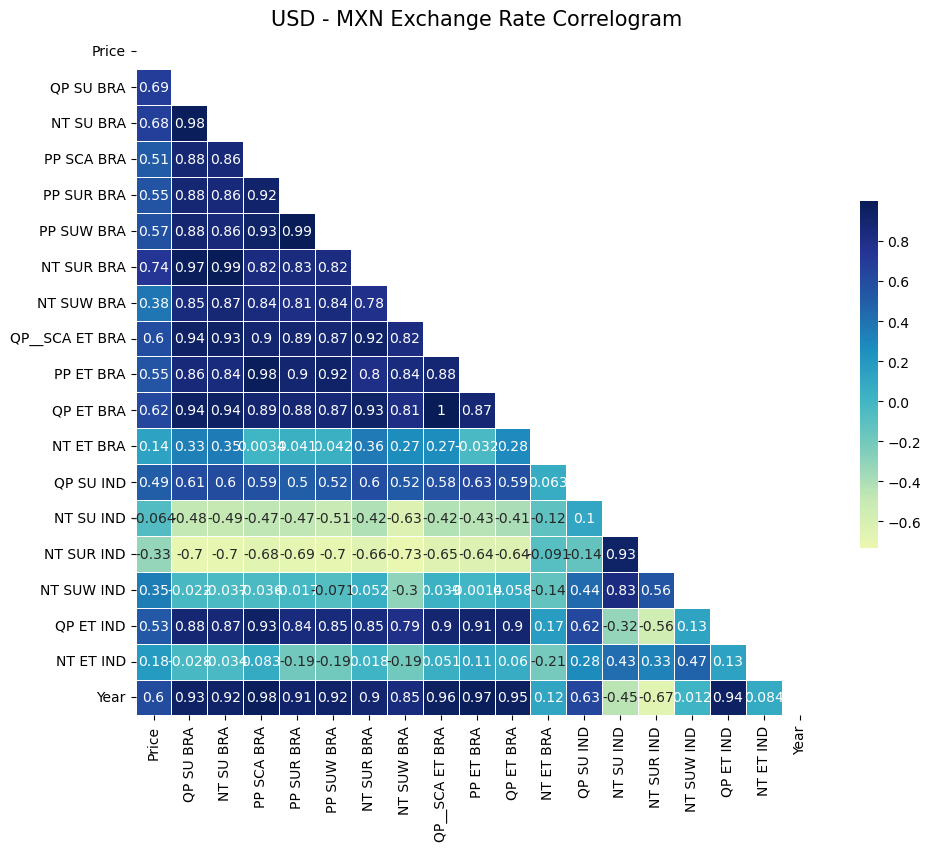

In [9]:
df = pd.concat([df_s11,
                df_brazil_production,
                df_brazil_production_trade,
                df_brazil_sugarcane_price,
                df_brazil_raw_sugar_price,
                df_brazil_white_sugar_price,
                df_brazil_raw_sugar_trade,
                df_brazil_white_sugar_trade,
                df_brazil_ethanol_sugarcane,
                df_brazil_ethanol_price,
                df_brazil_ethanol,
                df_brazil_ethanol_trade,
                df_india_production,
                df_india_production_trade,
                df_india_raw_sugar_trade,
                df_india_white_sugar_trade,
                df_india_ethanol,
                df_india_ethanol_trade
               ],axis=1)
df['Year'] = df.index.year
corr = df.dropna().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
plt.title("USD - MXN Exchange Rate Correlogram",size=15)
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, cmap="YlGnBu")

### OLS Regression Model for Sugar No. 11 Futures Price

In [10]:
# Multivariate OLS
# Full OLS Regression Model (Reference)

OLS_model_full = smf.ols("Price ~ Year + Q('QP SU BRA') + Q('NT SU BRA') + Q('PP SCA BRA') + Q('PP SUR BRA') + Q('PP SUW BRA') +\
                             Q('NT SUR BRA') + Q('NT SUW BRA') + Q('QP__SCA ET BRA') + Q('PP ET BRA') + Q('QP ET BRA') + Q('NT ET BRA') + Q('QP SU IND') +\
                             Q('NT SU IND') + Q('NT SUR IND') + Q('NT SUW IND') + Q('QP ET IND') + Q('NT ET IND')",data=df.dropna()).fit()


OLS_model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     8.157
Date:                Mon, 08 Jul 2024   Prob (F-statistic):            0.00448
Time:                        19:34:05   Log-Likelihood:                -40.686
No. Observations:                  25   AIC:                             117.4
Df Residuals:                       7   BIC:                             139.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1628.9332   5939.935      0.274      0.792   -1.24e+04    1.57e+04
Year                   -0.8342      2.991     -0.279      0.788      -7.906       6.238
Q('QP SU BRA')          0.0014      0.001      1.945      0.093      -0.000       0.003
Q('NT SU BRA')        -13.7256     10.336     -1.328      0.226     -38.165      10.714
Q('PP SCA BRA')         0.1524      0.409      0.372      0.721      -0.815       1.120
Q('PP SUR BRA')        -0.0165      0.028     -0.599      0.568      -0.082       0.049
Q('PP SUW BRA')         0.0287      0.015      1.874      0.103      -0.008       0.065
Q('NT SUR BRA')        13.7249     10.334      1.328      0.226     -10.712      38.162
Q('NT SUW BRA')        13.7275     10.338      1.328      0.226     -10.717      38.172
Q('QP__SCA ET BRA')    -0.0065      0.009     -0.728      0.490      -0.028       0.015
Q('PP ET BRA')          0.0610      0.170      0.360      0.730      -0.340       0.462
Q('QP ET BRA')          0.0058      0.009      0.642      0.541      -0.016       0.027
Q('NT ET BRA')          0.0019      0.002      0.907      0.395      -0.003       0.007
Q('QP SU IND')         -0.0006      0.000     -2.833      0.025      -0.001      -0.000
Q('NT SU IND')          0.0018      0.001      3.250      0.014       0.000       0.003
Q('NT SUR IND')        -0.0034      0.001     -2.344      0.052      -0.007    2.96e-05
Q('NT SUW IND')         0.0052      0.002      2.957      0.021       0.001       0.009
Q('QP ET IND')         -0.0103      0.004     -2.580      0.036      -0.020      -0.001
Q('NT ET IND')          0.0210      0.018      1.140      0.292      -0.023       0.065
==============================================================================
Omnibus:                        1.553   Durbin-Watson:                   2.905
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.156
Skew:                           0.515   Prob(JB):                        0.561
Kurtosis:                       2.780   Cond. No.                     5.58e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.23e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Backward Selection OLS Regression

Se utiliza la técnica de eliminación inversa, de forma que se inicia con un modelo OLS con todas las variables explanatorias y se eliminan una a una, comenzando desde la menos significativa estadísticamente (estableciendo un nivel de confianza del 95%), y corriendo recursivamente el modelo, hasta que todos los coeficientes tengan significancia estadística.

In [11]:
OLS_model_backward = smf.ols("Price ~ Q('QP SU BRA') + Q('NT SU BRA') + Q('PP SUW BRA') +\
                             Q('NT SUR BRA') + Q('NT SUW BRA') + Q('QP__SCA ET BRA') + Q('QP ET BRA') + Q('NT ET BRA') + Q('QP SU IND') +\
                             Q('NT SU IND') + Q('NT SUR IND') + Q('NT SUW IND') + Q('QP ET IND') + Q('NT ET IND')",data=df.dropna()).fit()


OLS_model_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     13.96
Date:                Mon, 08 Jul 2024   Prob (F-statistic):           5.34e-05
Time:                        19:34:05   Log-Likelihood:                -42.851
No. Observations:                  25   AIC:                             113.7
Df Residuals:                      11   BIC:                             130.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -31.1519      7.402     -4.208      0.001     -47.444     -14.860
Q('QP SU BRA')          0.0013      0.000      2.675      0.022       0.000       0.002
Q('NT SU BRA')        -17.4190      4.152     -4.195      0.001     -26.558      -8.280
Q('PP SUW BRA')         0.0261      0.005      5.100      0.000       0.015       0.037
Q('NT SUR BRA')        17.4180      4.152      4.195      0.001       8.279      26.557
Q('NT SUW BRA')        17.4218      4.153      4.195      0.001       8.281      26.562
Q('QP__SCA ET BRA')    -0.0072      0.002     -3.407      0.006      -0.012      -0.003
Q('QP ET BRA')          0.0059      0.002      2.781      0.018       0.001       0.011
Q('NT ET BRA')          0.0027      0.001      2.929      0.014       0.001       0.005
Q('QP SU IND')         -0.0006      0.000     -3.944      0.002      -0.001      -0.000
Q('NT SU IND')          0.0015      0.000      4.244      0.001       0.001       0.002
Q('NT SUR IND')        -0.0037      0.001     -3.809      0.003      -0.006      -0.002
Q('NT SUW IND')         0.0052      0.001      4.482      0.001       0.003       0.008
Q('QP ET IND')         -0.0099      0.002     -5.634      0.000      -0.014      -0.006
Q('NT ET IND')          0.0353      0.007      5.104      0.000       0.020       0.051
==============================================================================
Omnibus:                        0.783   Durbin-Watson:                   2.768
Prob(Omnibus):                  0.676   Jarque-Bera (JB):                0.630
Skew:                           0.362   Prob(JB):                        0.730
Kurtosis:                       2.718   Cond. No.                     5.51e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.31e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Entrenamiento OLS Regression
Se realiza el entrenamiento final. Con el propósito de conocer la **importancia de los factores** se escalará el conjunto de datos al rango [0,1], de forma que los coeficientes muestren la importancia.

In [12]:
scaler = MinMaxScaler()
df_scaled = df.dropna().copy()
features = df_scaled.columns.to_list()
features.pop(0)
df_scaled[features] = scaler.fit_transform(df_scaled[features])
df_scaled

,Price,QP SU BRA,NT SU BRA,PP SCA BRA,PP SUR BRA,PP SUW BRA,NT SUR BRA,NT SUW BRA,QP__SCA ET BRA,PP ET BRA,QP ET BRA,NT ET BRA,QP SU IND,NT SU IND,NT SUR IND,NT SUW IND,QP ET IND,NT ET IND,Year
2000-01-01,8.146667,0.000000,0.000000,0.000000,0.031095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.467092,0.583124,0.172445,0.000000,0.657617,0.000000
2001-01-01,8.247500,0.141357,0.146714,0.011675,0.000000,0.063062,0.098333,0.300817,0.020544,0.120293,0.031750,0.007421,1.000000,0.591913,0.588304,0.422842,0.000000,0.657617,0.041667
2002-01-01,6.420000,0.209641,0.153292,0.102254,0.121314,0.131452,0.164868,0.116421,0.055766,0.010243,0.077881,0.117921,0.668571,0.654543,0.583124,0.559030,0.459808,0.680913,0.083333
2003-01-01,6.956667,0.259129,0.267738,0.115083,0.097813,0.165605,0.248998,0.327428,0.142243,0.096995,0.166195,0.118711,0.463536,0.438963,0.496074,0.232495,0.420373,0.636512,0.125000
2004-01-01,7.535000,0.344107,0.400541,0.127913,0.223081,0.241786,0.388724,0.438178,0.130237,0.048652,0.163520,0.443134,0.431722,0.310296,0.336174,0.184002,0.341213,0.000000,0.166667
2005-01-01,10.257500,0.423613,0.317035,0.140743,0.406851,0.367418,0.363544,0.168891,0.187738,0.137172,0.213944,0.480682,0.641638,0.539831,0.556725,0.358260,0.342864,0.105147,0.208333
2006-01-01,14.522500,0.418815,0.536970,0.153573,0.142919,0.178968,0.544806,0.512011,0.262001,0.232874,0.292757,0.646651,0.929862,0.799912,0.770760,0.604351,0.466897,0.628730,0.250000
2007-01-01,9.946667,0.460292,0.408869,0.166403,0.151722,0.145909,0.405845,0.418501,0.465105,0.120939,0.485425,0.669223,0.873406,1.000000,1.000000,0.706096,0.533884,0.689032,0.291667
2008-01-01,12.150833,0.568111,0.633640,0.179232,0.238359,0.212798,0.665765,0.531313,0.667712,0.124837,0.672929,1.000000,0.488177,0.333919,0.274185,0.316791,0.523734,0.504139,0.333333
2009-01-01,18.629167,0.814996,0.779159,0.217080,0.518986,0.495100,0.805844,0.694159,0.611920,0.150186,0.629211,0.644494,0.624336,0.000000,0.000000,0.000000,0.349418,0.077490,0.375000


In [13]:
OLS_model_backward_scaled = smf.ols("Price ~ Q('QP SU BRA') + Q('NT SU BRA') + Q('PP SUW BRA') +\
                             Q('NT SUR BRA') + Q('NT SUW BRA') + Q('QP__SCA ET BRA') + Q('QP ET BRA') + Q('NT ET BRA') + Q('QP SU IND') +\
                             Q('NT SU IND') + Q('NT SUR IND') + Q('NT SUW IND') + Q('QP ET IND') + Q('NT ET IND')",data=df_scaled).fit()



OLS_model_backward_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     13.96
Date:                Mon, 08 Jul 2024   Prob (F-statistic):           5.34e-05
Time:                        19:34:05   Log-Likelihood:                -42.851
No. Observations:                  25   AIC:                             113.7
Df Residuals:                      11   BIC:                             130.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.5308      2.711     -1.303      0.219      -9.497       2.435
Q('QP SU BRA')         32.7284     12.236      2.675      0.022       5.797      59.660
Q('NT SU BRA')       -3.89e+05   9.27e+04     -4.195      0.001   -5.93e+05   -1.85e+05
Q('PP SUW BRA')        37.4236      7.338      5.100      0.000      21.272      53.575
Q('NT SUR BRA')      2.961e+05   7.06e+04      4.195      0.001    1.41e+05    4.51e+05
Q('NT SUW BRA')      9.297e+04   2.22e+04      4.195      0.001    4.42e+04    1.42e+05
Q('QP__SCA ET BRA')  -164.0103     48.133     -3.407      0.006    -269.950     -58.070
Q('QP ET BRA')        144.4976     51.961      2.781      0.018      30.132     258.863
Q('NT ET BRA')         13.6644      4.665      2.929      0.014       3.397      23.932
Q('QP SU IND')        -17.7917      4.511     -3.944      0.002     -27.721      -7.862
Q('NT SU IND')          3.5915      1.648      2.180      0.052      -0.035       7.218
Q('NT SUR IND')       -15.1899      4.769     -3.185      0.009     -25.686      -4.694
Q('NT SUW IND')        28.0077      6.104      4.588      0.001      14.573      41.442
Q('QP ET IND')        -31.5601      5.602     -5.634      0.000     -43.889     -19.231
Q('NT ET IND')         20.6364      4.044      5.104      0.000      11.737      29.536
==============================================================================
Omnibus:                        0.783   Durbin-Watson:                   2.768
Prob(Omnibus):                  0.676   Jarque-Bera (JB):                0.630
Skew:                           0.362   Prob(JB):                        0.730
Kurtosis:                       2.718   Cond. No.                     1.47e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.73e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [14]:
def plot_feature_importance(params,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(params.values)
    feature_names = np.array(params.index)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

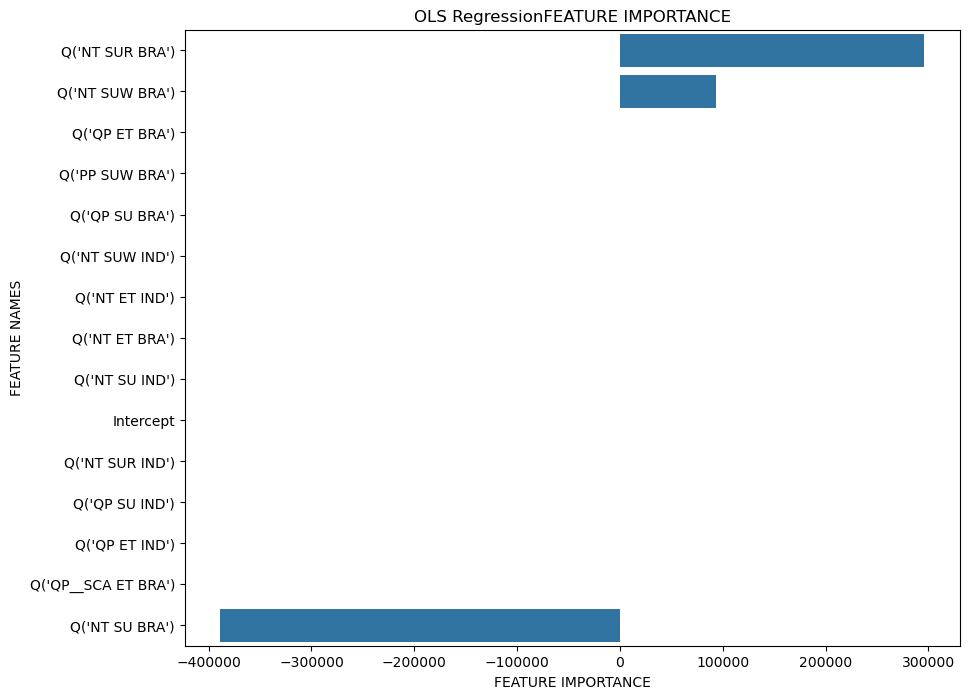

In [15]:
plot_feature_importance(OLS_model_backward_scaled.params,'OLS Regression')

### Predicciones

In [16]:
# Generate Predictions
explanatories = ['QP SU BRA','NT SU BRA','PP SUW BRA','NT SUR BRA','NT SUW BRA','QP__SCA ET BRA','QP ET BRA','NT ET BRA',
                 'QP SU IND','NT SU IND','NT SUR IND','NT SUW IND','QP ET IND','NT ET IND']
s11_hat = OLS_model_backward_scaled.predict(df_scaled[explanatories])

Text(0.5, 1.0, 'Sugar No. 11 Futures Price')

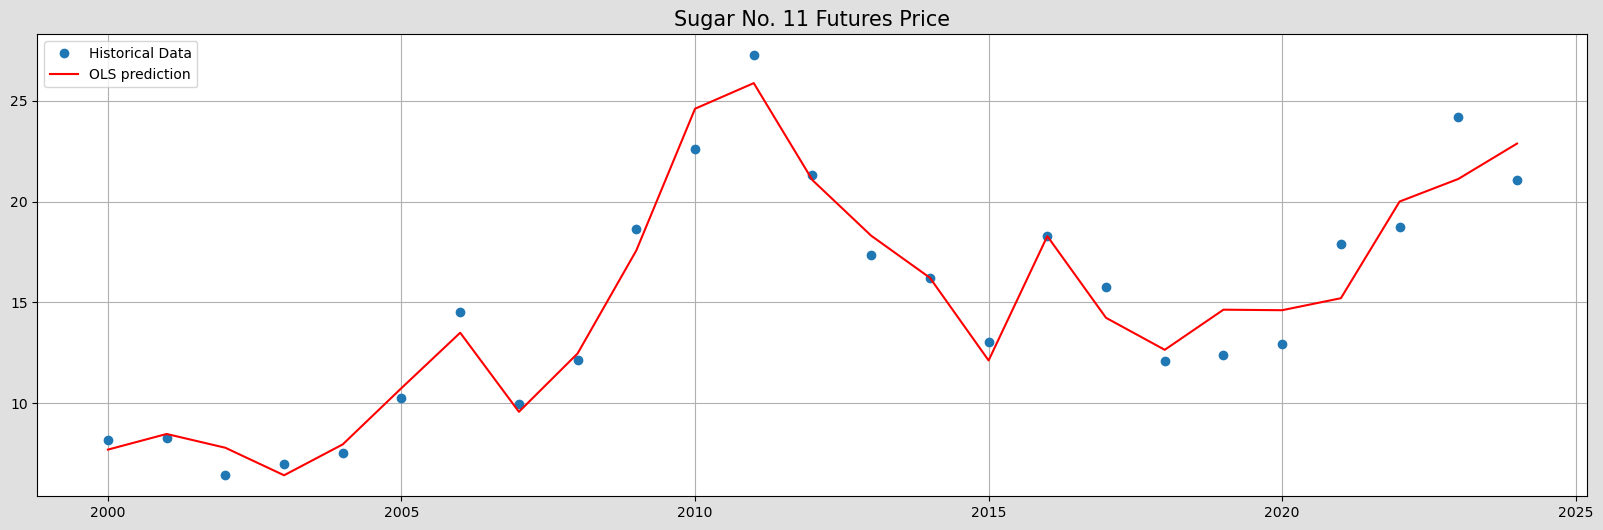

In [17]:
# Plot Predictions vs. Actuals
fig, ax = plt.subplots(figsize=(20,6))
fig.patch.set_facecolor('#E0E0E0')
plt.grid(zorder=0)
ax.plot(df.dropna()['Year'], df.dropna()['Price'], "o", label="Historical Data")
ax.plot(df.dropna()['Year'], s11_hat, "r", label="OLS prediction")
ax.legend(loc="upper left")
plt.title("Sugar No. 11 Futures Price",size=15)